### Libs

In [10]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

### Helper

In [58]:
def normalization(x):
    """
    Args:
        x : np.array : (H, W)

    Return:
        np.array : (H, W)
    """
    x = x - x.min()
    x = x / x.max()
    x = x - 0.5
    return  x / 0.5

In [21]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

In [11]:
class Anomaly_Dataset(Dataset):
    def __init__(self,
                 root
                 ):
        super(Anomaly_Dataset, self).__init__()

        self.data = Anomaly_Dataset.load_dataset(root)
        self.image, self.label = Anomaly_Dataset.get_numpy(self.data)

    def __getitem__(self, item):
        x, y =  self.image[item], self.label[item]

        # RGB -> GRAY : (H, W)
        x = x[:,:,0]

        # (1, H, W)
        x = Anomaly_Dataset.normalization(x)
        #x = np.expand_dims(x, axis=0)

        return x, y


    def __len__(self):
        return len(self.data)


    @staticmethod
    def load_dataset(path):
        img_rows = 128
        img_cols = 128
        return image_dataset_from_directory(directory = path,
                                               label_mode = 'int',
                                               color_mode = 'rgb',
                                               shuffle = False,
                                               batch_size = None,
                                               image_size = (img_rows, img_cols),
                                               crop_to_aspect_ratio = True)

    @staticmethod
    def get_numpy(PrefetchDataset):
        """
        return:
            (N, H, W, C) , (N,)
        """
        images = []
        labels = []
        for (image, label) in PrefetchDataset:
            images.append(image)
            labels.append(label)
        return np.array(images), np.array(labels)

    @staticmethod
    def rgb_2_gray(x):
        """
        (H, W, C) --> (H, W)
        """
        return cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

    @staticmethod
    def normalization(x):
        """
        Args:
            x : np.array : (H, W)

        Return:
            np.array : (H, W)
        """
        x = x - x.min(keepdims=True)
        x = x / x.max(keepdims=True)
        x = x - 0.5
        return  x / 0.5

### Net : It should be same as ...

In [12]:
class Encoder(nn.Module):

    def __init__(self, in_channels, init_features):
        super(Encoder, self).__init__()

        features = init_features
        self.encoder1 = Encoder._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = Encoder._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = Encoder._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = Encoder._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = Encoder._block(features * 8, features * 16, name="bottleneck")


    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))

        return bottleneck, enc4, enc3, enc2, enc1


    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [13]:
class Decoder(nn.Module):

    def __init__(self, init_features, out_channels):
        super(Decoder, self).__init__()

        features = init_features

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = Decoder._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = Decoder._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = Decoder._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = Decoder._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, bottleneck, enc4, enc3, enc2, enc1):
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.tanh(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [14]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels, init_features):
        super(Generator, self).__init__()

        features = init_features
        self.encoder = Encoder(in_channels, features)
        self.decoder = Decoder(features, out_channels)

    def forward(self, x):
        self.bottleneck, self.enc4, self.enc3, self.enc2, self.enc1 = self.encoder(x)
        x_hat = self.decoder(self.bottleneck, self.enc4, self.enc3, self.enc2, self.enc1)
        return x_hat

In [15]:
# Change activation to RELU
class Critic(nn.Module):
    def __init__(self , c_dim , df_dim):
        super(Critic, self).__init__()

        # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
        #                          output_padding=0,groups=1, bias=True, dilation=1, padding_mode='zeros')

        self.critic = nn.Sequential(
            Critic._block(c_dim, df_dim),
            Critic._block(df_dim, df_dim*2),
            Critic._block(df_dim*2, df_dim*4),
            Critic._block(df_dim*4, 1, padding=0, final_layer=True),
        )

    def forward(self,inp):
        return self.critic(
            inp
        ).flatten(1) # (N , 1 , 1, 1 )

    @staticmethod
    def _block(in_channels, out_channels, kernel_size=4, stride=3, padding=1, final_layer=False):
        if final_layer:
            return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )

### Hyper

In [177]:
device = 'cuda'

lr_decoder = 0.001
beta_1 = 0.5
beta_2 = 0.999

# epochs
epochs= 660
disp_freq=20
display_step=20

crit_repeats=5
c_lambda = 10

step_bins = 1

### Dataset

In [178]:
# Best Generator and Criti
c_dim , gf_dim = 1, 8
df_dim = 64
gen = Generator(c_dim, c_dim, gf_dim).to(device)
crit = Critic(c_dim, df_dim).to(device)

best_model = torch.load("./../epoch_174_loss_0.25_best_model.pt")

gen.load_state_dict(best_model['Generator'])
crit.load_state_dict(best_model['Critic'])

<All keys matched successfully>

In [179]:
# Abnormal Tumar
root = "./../dataset/kaggle1/tamiz"
dataset = Anomaly_Dataset(root)
test_loader = DataLoader(dataset, batch_size=1)

Found 1 files belonging to 1 classes.


<Figure size 432x288 with 0 Axes>

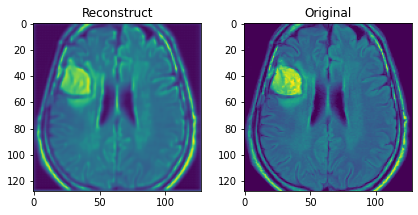

In [180]:
for image_test,_ in test_loader:
    image_test = image_test.unsqueeze(1).to(device)
    image_hat = gen(image_test)
i=0
plt.figure()
ploter(image_test[i,0].detach().cpu(), image_hat[i,0].detach().cpu())
plt.show()

### Load best

In [181]:
bottleneck, enc4, enc3, enc2, enc1 = gen.encoder(image_test)
x_hat = gen.decoder(bottleneck, enc4, enc3, enc2, enc1)
bottleneck = Parameter(bottleneck)
enc4 = Parameter(enc4)
enc3 = Parameter(enc3)
enc2 = Parameter(enc2)
enc1 = Parameter(enc1)

In [182]:
# Optimizers
optim_decoder = torch.optim.Adam([bottleneck, enc4, enc3, enc2, enc1], lr=lr_decoder, betas=(beta_1, beta_2))

In [183]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [184]:
cur_step = 0
decoder_losses = []

############################################################
###### Epoch 1 #############################################
############################################################
############################################################
###### Epoch 2 #############################################
############################################################
############################################################
###### Epoch 3 #############################################
############################################################
############################################################
###### Epoch 4 #############################################
############################################################
############################################################
###### Epoch 5 #############################################
############################################################
############################################################
###### Epoch 6 #########

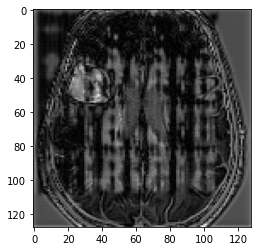

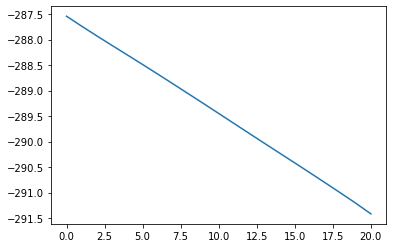

############################################################
###### Epoch 22 #############################################
############################################################
############################################################
###### Epoch 23 #############################################
############################################################
############################################################
###### Epoch 24 #############################################
############################################################
############################################################
###### Epoch 25 #############################################
############################################################
############################################################
###### Epoch 26 #############################################
############################################################
############################################################
###### Epoch 27 ###

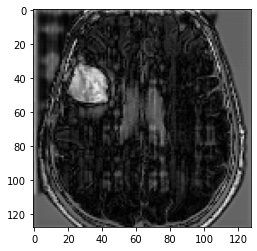

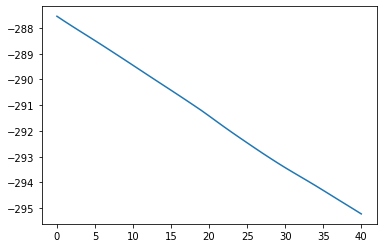

############################################################
###### Epoch 42 #############################################
############################################################
############################################################
###### Epoch 43 #############################################
############################################################
############################################################
###### Epoch 44 #############################################
############################################################
############################################################
###### Epoch 45 #############################################
############################################################
############################################################
###### Epoch 46 #############################################
############################################################
############################################################
###### Epoch 47 ###

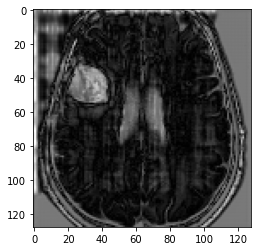

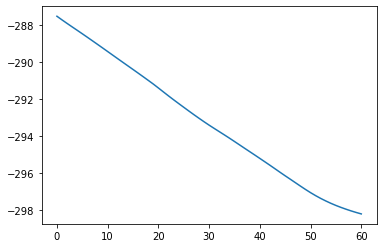

############################################################
###### Epoch 62 #############################################
############################################################
############################################################
###### Epoch 63 #############################################
############################################################
############################################################
###### Epoch 64 #############################################
############################################################
############################################################
###### Epoch 65 #############################################
############################################################
############################################################
###### Epoch 66 #############################################
############################################################
############################################################
###### Epoch 67 ###

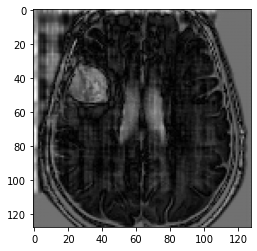

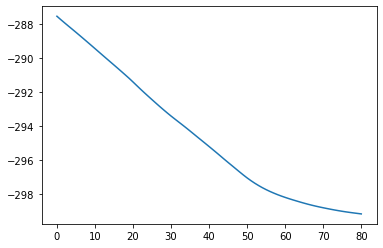

############################################################
###### Epoch 82 #############################################
############################################################
############################################################
###### Epoch 83 #############################################
############################################################
############################################################
###### Epoch 84 #############################################
############################################################
############################################################
###### Epoch 85 #############################################
############################################################
############################################################
###### Epoch 86 #############################################
############################################################
############################################################
###### Epoch 87 ###

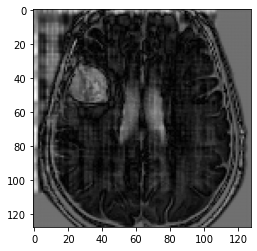

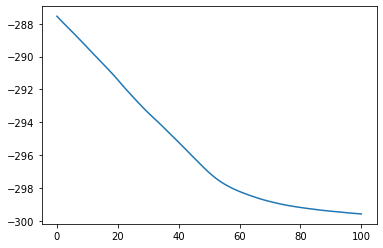

############################################################
###### Epoch 102 #############################################
############################################################
############################################################
###### Epoch 103 #############################################
############################################################
############################################################
###### Epoch 104 #############################################
############################################################
############################################################
###### Epoch 105 #############################################
############################################################
############################################################
###### Epoch 106 #############################################
############################################################
############################################################
###### Epoch 1

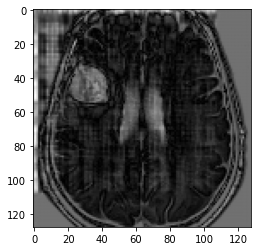

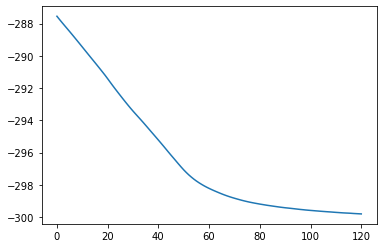

############################################################
###### Epoch 122 #############################################
############################################################
############################################################
###### Epoch 123 #############################################
############################################################
############################################################
###### Epoch 124 #############################################
############################################################
############################################################
###### Epoch 125 #############################################
############################################################
############################################################
###### Epoch 126 #############################################
############################################################
############################################################
###### Epoch 1

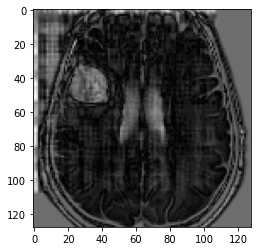

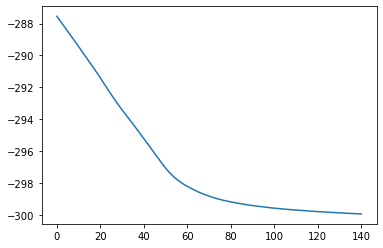

############################################################
###### Epoch 142 #############################################
############################################################
############################################################
###### Epoch 143 #############################################
############################################################
############################################################
###### Epoch 144 #############################################
############################################################
############################################################
###### Epoch 145 #############################################
############################################################
############################################################
###### Epoch 146 #############################################
############################################################
############################################################
###### Epoch 1

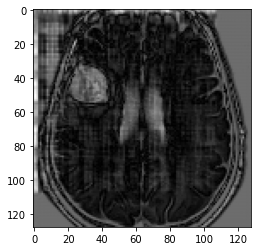

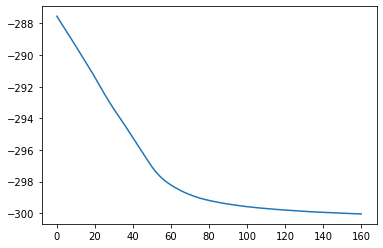

############################################################
###### Epoch 162 #############################################
############################################################
############################################################
###### Epoch 163 #############################################
############################################################
############################################################
###### Epoch 164 #############################################
############################################################
############################################################
###### Epoch 165 #############################################
############################################################
############################################################
###### Epoch 166 #############################################
############################################################
############################################################
###### Epoch 1

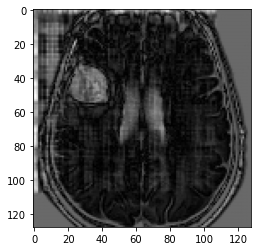

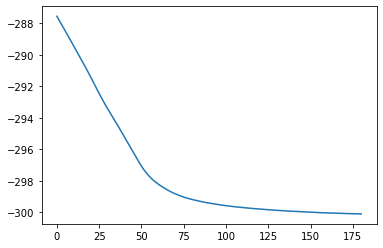

############################################################
###### Epoch 182 #############################################
############################################################
############################################################
###### Epoch 183 #############################################
############################################################
############################################################
###### Epoch 184 #############################################
############################################################
############################################################
###### Epoch 185 #############################################
############################################################
############################################################
###### Epoch 186 #############################################
############################################################
############################################################
###### Epoch 1

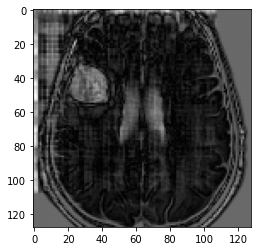

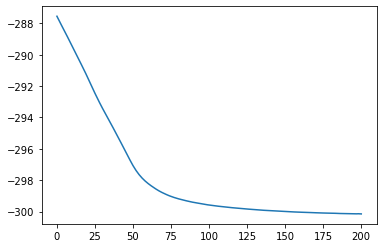

############################################################
###### Epoch 202 #############################################
############################################################
############################################################
###### Epoch 203 #############################################
############################################################
############################################################
###### Epoch 204 #############################################
############################################################
############################################################
###### Epoch 205 #############################################
############################################################
############################################################
###### Epoch 206 #############################################
############################################################
############################################################
###### Epoch 2

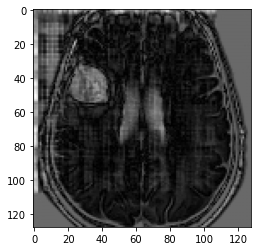

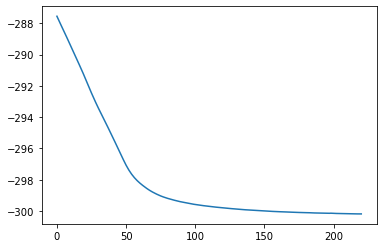

############################################################
###### Epoch 222 #############################################
############################################################
############################################################
###### Epoch 223 #############################################
############################################################
############################################################
###### Epoch 224 #############################################
############################################################
############################################################
###### Epoch 225 #############################################
############################################################
############################################################
###### Epoch 226 #############################################
############################################################
############################################################
###### Epoch 2

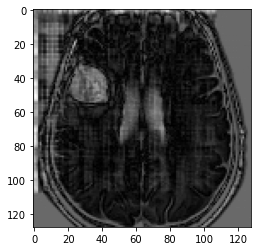

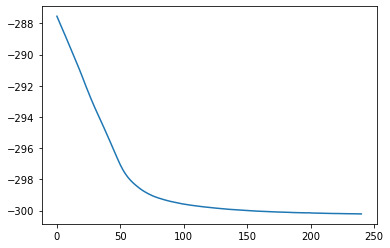

############################################################
###### Epoch 242 #############################################
############################################################
############################################################
###### Epoch 243 #############################################
############################################################
############################################################
###### Epoch 244 #############################################
############################################################
############################################################
###### Epoch 245 #############################################
############################################################
############################################################
###### Epoch 246 #############################################
############################################################
############################################################
###### Epoch 2

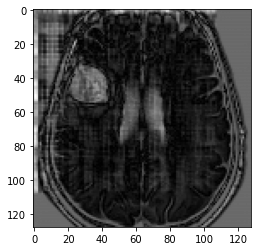

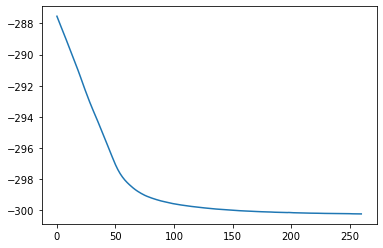

############################################################
###### Epoch 262 #############################################
############################################################
############################################################
###### Epoch 263 #############################################
############################################################
############################################################
###### Epoch 264 #############################################
############################################################
############################################################
###### Epoch 265 #############################################
############################################################
############################################################
###### Epoch 266 #############################################
############################################################
############################################################
###### Epoch 2

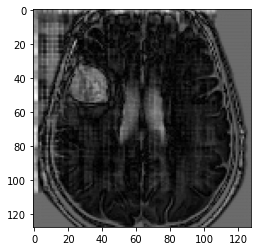

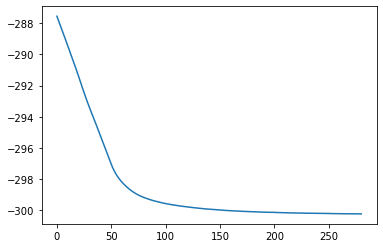

############################################################
###### Epoch 282 #############################################
############################################################
############################################################
###### Epoch 283 #############################################
############################################################
############################################################
###### Epoch 284 #############################################
############################################################
############################################################
###### Epoch 285 #############################################
############################################################
############################################################
###### Epoch 286 #############################################
############################################################
############################################################
###### Epoch 2

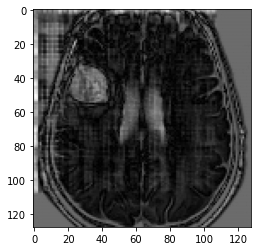

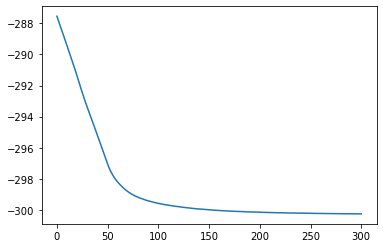

############################################################
###### Epoch 302 #############################################
############################################################
############################################################
###### Epoch 303 #############################################
############################################################
############################################################
###### Epoch 304 #############################################
############################################################
############################################################
###### Epoch 305 #############################################
############################################################
############################################################
###### Epoch 306 #############################################
############################################################
############################################################
###### Epoch 3

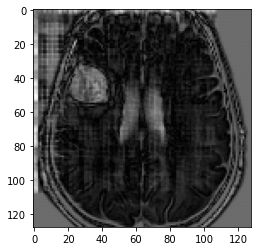

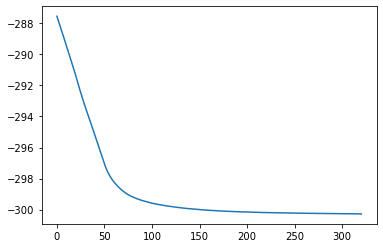

############################################################
###### Epoch 322 #############################################
############################################################
############################################################
###### Epoch 323 #############################################
############################################################
############################################################
###### Epoch 324 #############################################
############################################################
############################################################
###### Epoch 325 #############################################
############################################################
############################################################
###### Epoch 326 #############################################
############################################################
############################################################
###### Epoch 3

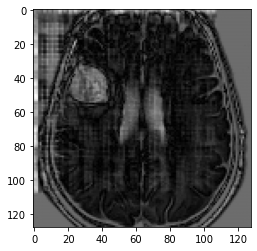

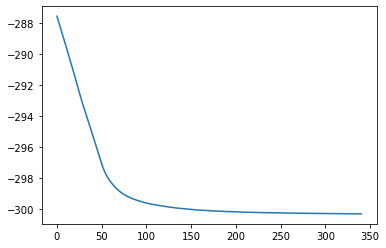

############################################################
###### Epoch 342 #############################################
############################################################
############################################################
###### Epoch 343 #############################################
############################################################
############################################################
###### Epoch 344 #############################################
############################################################
############################################################
###### Epoch 345 #############################################
############################################################
############################################################
###### Epoch 346 #############################################
############################################################
############################################################
###### Epoch 3

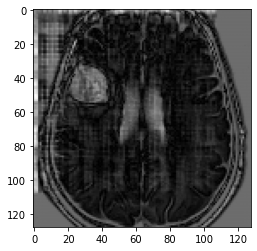

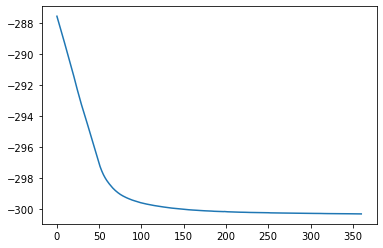

############################################################
###### Epoch 362 #############################################
############################################################
############################################################
###### Epoch 363 #############################################
############################################################
############################################################
###### Epoch 364 #############################################
############################################################
############################################################
###### Epoch 365 #############################################
############################################################
############################################################
###### Epoch 366 #############################################
############################################################
############################################################
###### Epoch 3

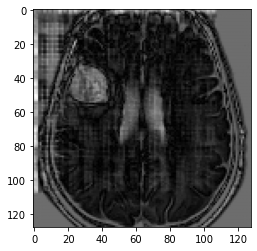

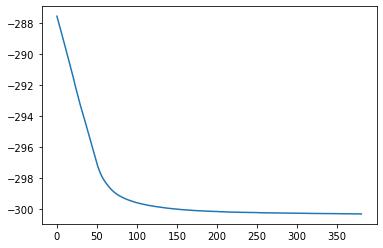

############################################################
###### Epoch 382 #############################################
############################################################
############################################################
###### Epoch 383 #############################################
############################################################
############################################################
###### Epoch 384 #############################################
############################################################
############################################################
###### Epoch 385 #############################################
############################################################
############################################################
###### Epoch 386 #############################################
############################################################
############################################################
###### Epoch 3

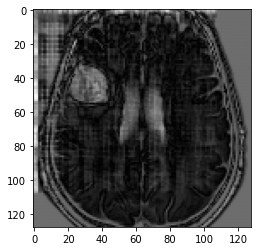

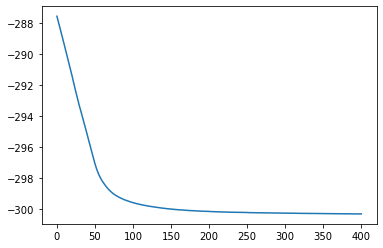

############################################################
###### Epoch 402 #############################################
############################################################
############################################################
###### Epoch 403 #############################################
############################################################
############################################################
###### Epoch 404 #############################################
############################################################
############################################################
###### Epoch 405 #############################################
############################################################
############################################################
###### Epoch 406 #############################################
############################################################
############################################################
###### Epoch 4

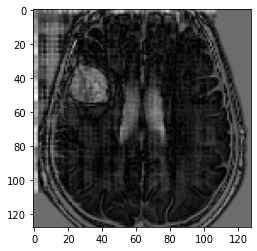

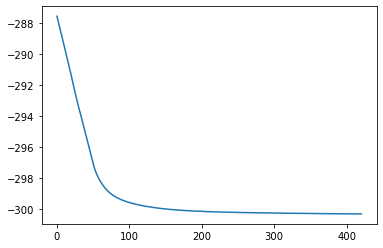

############################################################
###### Epoch 422 #############################################
############################################################
############################################################
###### Epoch 423 #############################################
############################################################
############################################################
###### Epoch 424 #############################################
############################################################
############################################################
###### Epoch 425 #############################################
############################################################
############################################################
###### Epoch 426 #############################################
############################################################
############################################################
###### Epoch 4

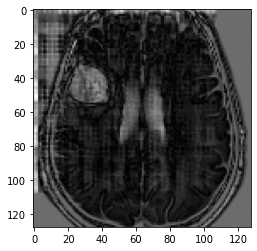

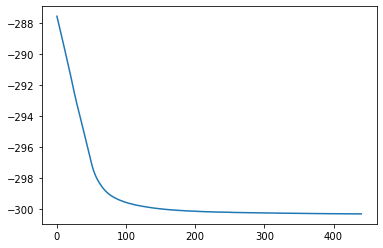

############################################################
###### Epoch 442 #############################################
############################################################
############################################################
###### Epoch 443 #############################################
############################################################
############################################################
###### Epoch 444 #############################################
############################################################
############################################################
###### Epoch 445 #############################################
############################################################
############################################################
###### Epoch 446 #############################################
############################################################
############################################################
###### Epoch 4

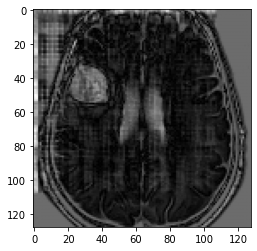

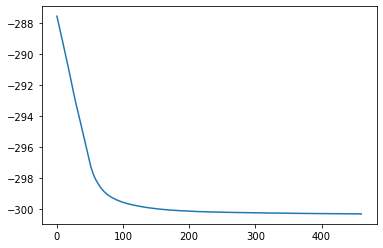

############################################################
###### Epoch 462 #############################################
############################################################
############################################################
###### Epoch 463 #############################################
############################################################
############################################################
###### Epoch 464 #############################################
############################################################
############################################################
###### Epoch 465 #############################################
############################################################
############################################################
###### Epoch 466 #############################################
############################################################
############################################################
###### Epoch 4

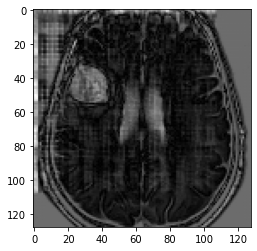

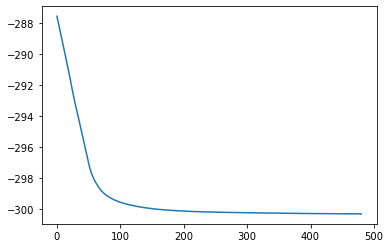

############################################################
###### Epoch 482 #############################################
############################################################
############################################################
###### Epoch 483 #############################################
############################################################
############################################################
###### Epoch 484 #############################################
############################################################
############################################################
###### Epoch 485 #############################################
############################################################
############################################################
###### Epoch 486 #############################################
############################################################
############################################################
###### Epoch 4

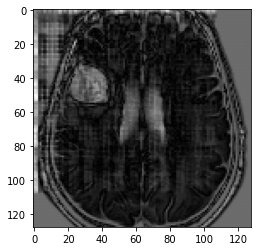

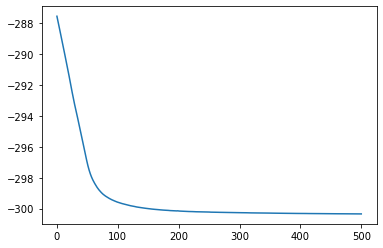

############################################################
###### Epoch 502 #############################################
############################################################
############################################################
###### Epoch 503 #############################################
############################################################
############################################################
###### Epoch 504 #############################################
############################################################
############################################################
###### Epoch 505 #############################################
############################################################
############################################################
###### Epoch 506 #############################################
############################################################
############################################################
###### Epoch 5

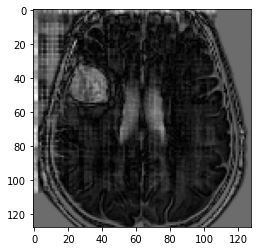

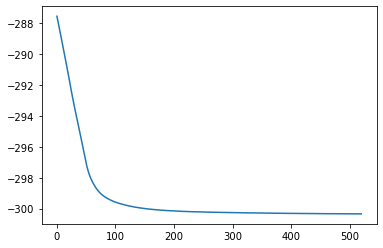

############################################################
###### Epoch 522 #############################################
############################################################
############################################################
###### Epoch 523 #############################################
############################################################
############################################################
###### Epoch 524 #############################################
############################################################
############################################################
###### Epoch 525 #############################################
############################################################
############################################################
###### Epoch 526 #############################################
############################################################
############################################################
###### Epoch 5

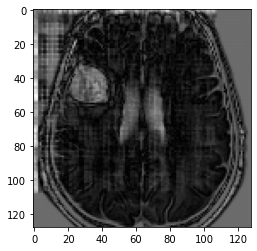

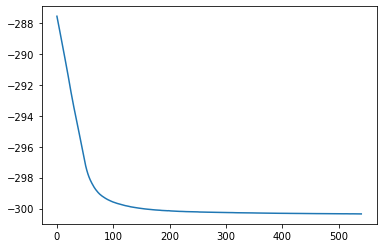

############################################################
###### Epoch 542 #############################################
############################################################
############################################################
###### Epoch 543 #############################################
############################################################
############################################################
###### Epoch 544 #############################################
############################################################
############################################################
###### Epoch 545 #############################################
############################################################
############################################################
###### Epoch 546 #############################################
############################################################
############################################################
###### Epoch 5

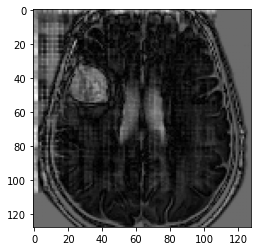

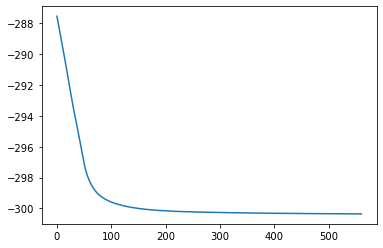

############################################################
###### Epoch 562 #############################################
############################################################
############################################################
###### Epoch 563 #############################################
############################################################
############################################################
###### Epoch 564 #############################################
############################################################
############################################################
###### Epoch 565 #############################################
############################################################
############################################################
###### Epoch 566 #############################################
############################################################
############################################################
###### Epoch 5

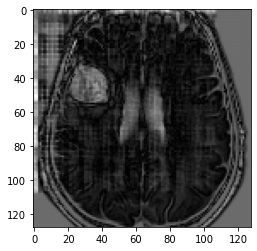

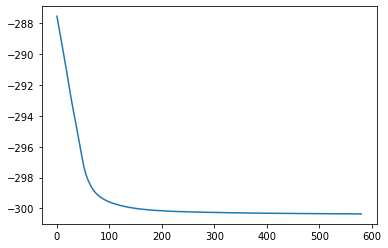

############################################################
###### Epoch 582 #############################################
############################################################
############################################################
###### Epoch 583 #############################################
############################################################
############################################################
###### Epoch 584 #############################################
############################################################
############################################################
###### Epoch 585 #############################################
############################################################
############################################################
###### Epoch 586 #############################################
############################################################
############################################################
###### Epoch 5

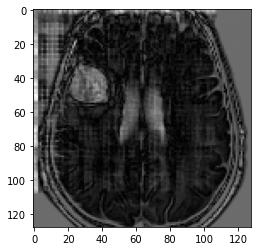

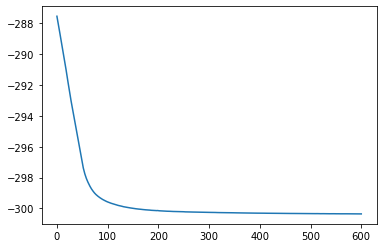

############################################################
###### Epoch 602 #############################################
############################################################
############################################################
###### Epoch 603 #############################################
############################################################
############################################################
###### Epoch 604 #############################################
############################################################
############################################################
###### Epoch 605 #############################################
############################################################
############################################################
###### Epoch 606 #############################################
############################################################
############################################################
###### Epoch 6

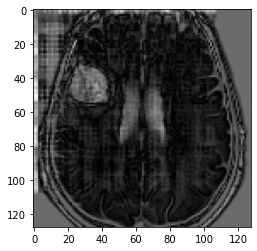

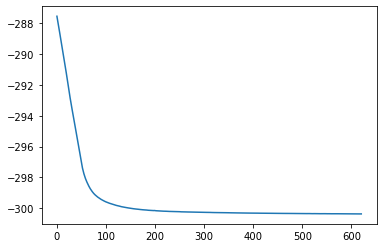

############################################################
###### Epoch 622 #############################################
############################################################
############################################################
###### Epoch 623 #############################################
############################################################
############################################################
###### Epoch 624 #############################################
############################################################
############################################################
###### Epoch 625 #############################################
############################################################
############################################################
###### Epoch 626 #############################################
############################################################
############################################################
###### Epoch 6

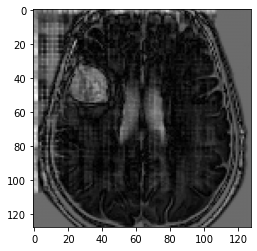

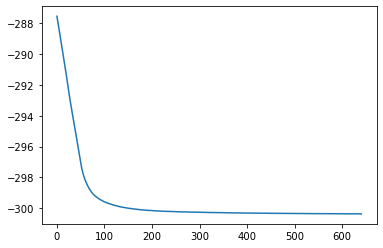

############################################################
###### Epoch 642 #############################################
############################################################
############################################################
###### Epoch 643 #############################################
############################################################
############################################################
###### Epoch 644 #############################################
############################################################
############################################################
###### Epoch 645 #############################################
############################################################
############################################################
###### Epoch 646 #############################################
############################################################
############################################################
###### Epoch 6

In [185]:
for epoch in range(1,epochs+1):
    print(60 * "#")
    print(6 * "#" + " Epoch " + str(epoch) + " " + 45 * "#")
    print(60 * "#")

    # Set mode on "train mode"
    gen.train()
    crit.eval()
    for image_test,_ in test_loader:
        cur_batch_size = len(image_test)

        image_test = image_test.unsqueeze(1).to(device)

        # Decoder Star Learning
        optim_decoder.zero_grad()
        image_hat = gen.decoder(bottleneck, enc4, enc3, enc2, enc1)
        decoder_loss = ( -crit(image_hat) ).mean(dim=0)
        decoder_loss.backward(retain_graph=True)
        optim_decoder.step()
        decoder_losses += [decoder_loss.item()]

    ### Visualization code ###
    if cur_step % display_step == 0 and cur_step > 0:
        decoder_mean = sum(decoder_losses[-display_step:]) / display_step
        print(f"Epoch {epoch}, step {cur_step}: Generator loss: {decoder_mean}")


        plt.figure()
        #i=0
        #ploter(image_test[i,0].detach().cpu(), image_hat[i,0].detach().cpu())
        #plt.show()
        diff = (normalization(image_hat[0][0]) - image_test[0][0]).abs()
        plt.imshow(diff.detach().cpu(), cmap='gray')
        plt.show()


        plt.figure()
        num_examples = (len(decoder_losses) // step_bins) * step_bins
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(decoder_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Decoder Loss"
        )
        plt.show()
    cur_step += 1

### End

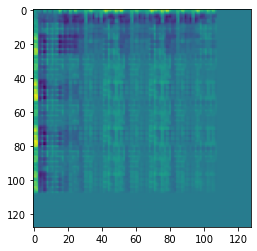

In [186]:
plt.imshow(image_hat[0][0].detach().cpu())